In [1]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.metrics import recall_score, roc_auc_score
import os
import pickle
from dotenv import load_dotenv
from preprocess import preprocess
import numpy as np

load_dotenv(override=True)

True

In [2]:
dat = pd.read_parquet(os.getenv('TEST_PARQUET'))
dat.shape

(2867, 432)

In [3]:
preprocess(dat)
dat.shape

parity is NaN 1041; will be filled with 0
dropping 26 of census tract columns
found columns with NaN: bmi, NaN number = 70, dropping these patients
found columns with NaN: mother_age, NaN number = 4, dropping these patients
found columns with NaN: mother_height, NaN number = 128, dropping these patients
found columns with NaN: smoking, NaN number = 1, dropping these patients
found columns with NaN: tobacco, NaN number = 1, dropping these patients
removing patients without prenatal and postpartum visit 261
dropping columns: counts_of_visits_3m_after_delivery, counts_of_visits_6m_after_delivery
removing patients without screening using edinburgh or phq9 654
removing columns: 'F53_label','edinburgh_max','phq9_total_max', 'PPD_delete_label'


(1811, 402)

In [4]:
with open(os.getenv("ML_MODEL"), 'rb') as fid:
    clf = pickle.load(fid)

In [5]:
# prepare the X, y
X = dat.drop(columns=['birthid', 'label'])
y = dat['label']

In [6]:
# make prediction
y_pred = clf.predict(X)
y_pred_prob = clf.predict_proba(X)

In [7]:
# get various score
print('auc= {0:.3f}'.format(roc_auc_score(y, y_pred_prob[:, 1])))
print('specificity= {0:.3f}'.format(recall_score(y, y_pred, pos_label=0)))
print('sensitivity= {0:.3f}'.format(recall_score(y, y_pred)))

auc= 0.756
specificity= 0.905
sensitivity= 0.397


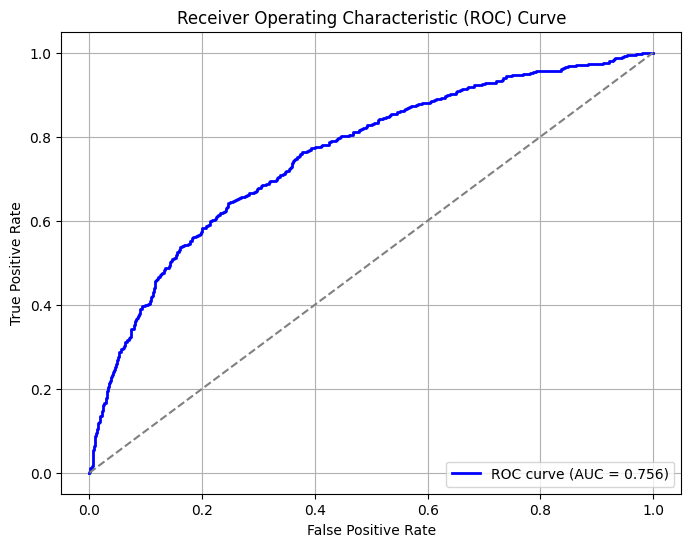

In [8]:
# make a plot for AUC curve

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y, y_pred_prob[:, 1])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y, y_pred_prob[:, 1]):.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [9]:
# we are particularly interested in performance among different races
# if this is run only on a subset, it may not be robust as there will only be a few hundred patient in the minority group
# check the result in the train.ipynb or use it for a larger dataset
race_cols = ['mother_is_black', 'mother_is_hispanic', 'mother_is_white']
for col in race_cols:
    idx = (X[col] == 1)
    y_selected = y[idx]
    y_pred_selected = y_pred[idx]
    y_pred_prob_selected = y_pred_prob[idx]
    print(f"====== for {col}: ======")
    print("N={0} positive rate = {1:.3f}".format(len(y_selected), y_selected.mean()))
    print('auc= {0:.3f}'.format(roc_auc_score(y_selected, y_pred_prob_selected[:, 1])))
    print('specificity= {0:.3f}'.format(recall_score(y_selected, y_pred_selected, pos_label=0)))
    print('sensitivity= {0:.3f}'.format(recall_score(y_selected, y_pred_selected)))

====== for mother_is_black: ======
N=387 positive rate = 0.282
auc= 0.738
specificity= 0.899
sensitivity= 0.459
====== for mother_is_hispanic: ======
N=319 positive rate = 0.138
auc= 0.757
specificity= 0.953
sensitivity= 0.250
====== for mother_is_white: ======
N=907 positive rate = 0.266
auc= 0.744
specificity= 0.877
sensitivity= 0.419
